# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [88]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [89]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [90]:
# Configure API key 

quandl.ApiConfig.api_key = '6QTbzrfwJs9imkwg7s8g'

In [91]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FFRED/NROU')

QuandlError: (Status 410) Something went wrong. Please try again. If you continue to have problems, please contact us at connect@quandl.com.

### since the file is no longer in the quandl, i imported it from this website 
https://fred.stlouisfed.org/graph/?id=NROU

In [92]:
path =r'/Users/juliapetke/Desktop/Julia Petke- Boat Sale'

In [93]:
df = pd.read_csv(os.path.join(path,'02 Data', 'Original Data','NROU.csv'), index_col = False)

In [94]:
df.head(5)

,DATE,NROU
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [95]:
df.shape

(344, 2)

In [96]:
df.columns

Index(['DATE', 'NROU'], dtype='object')

In [97]:
type(df)

pandas.core.frame.DataFrame

#### 2. Subsetting, wrangling, and cleaning time-series data

In [98]:
# Reset index so that you can use the "Date" column as a filter

df_2 = df.reset_index()

In [99]:
df_2.head()

,index,DATE,NROU
0,0,1949-01-01,5.255053
1,1,1949-04-01,5.261516
2,2,1949-07-01,5.268013
3,3,1949-10-01,5.274564
4,4,1950-01-01,5.281182


In [100]:
data_sub = df_2.loc[(df_2['DATE'] >= '1980-01-01') & (df_2['DATE'] < '2020-06-01')]

In [101]:
data_sub.shape

(162, 3)

In [102]:
data_sub.head()

,index,DATE,NROU
124,124,1980-01-01,6.217371
125,125,1980-04-01,6.210709
126,126,1980-07-01,6.203388
127,127,1980-10-01,6.195496
128,128,1981-01-01,6.187123


In [103]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['DATE']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['DATE'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,index,NROU
datetime,,
1980-01-01,124,6.217371
1980-04-01,125,6.210709
1980-07-01,126,6.203388
1980-10-01,127,6.195496
1981-01-01,128,6.187123


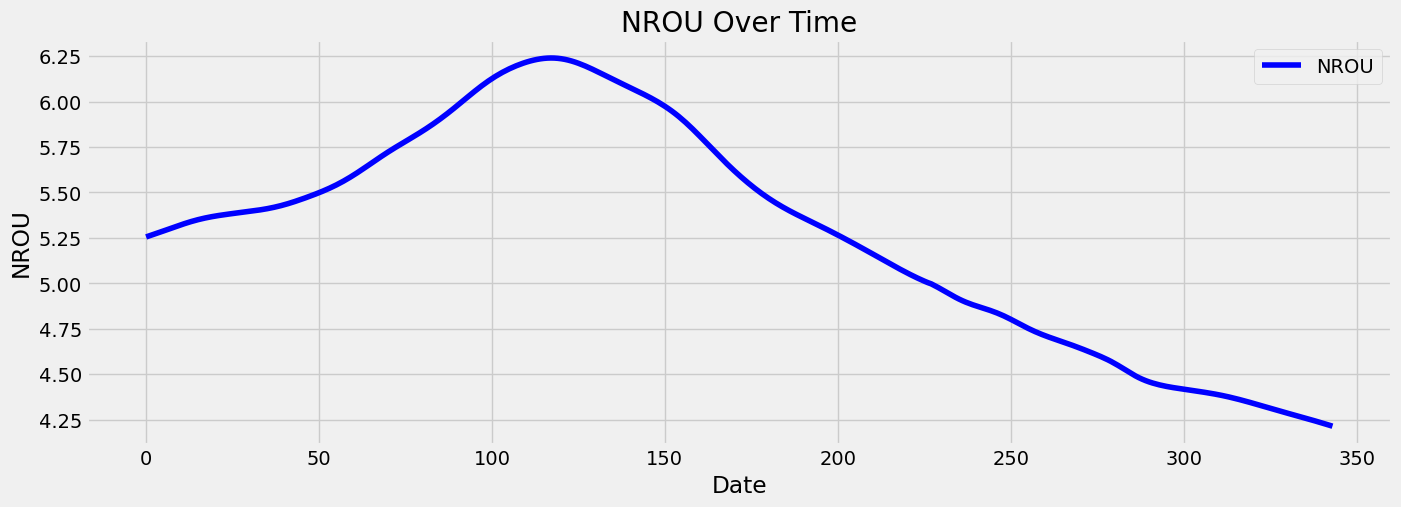

In [45]:
plt.figure(figsize=(15, 5), dpi=100)

# Plotting NROU over time
plt.plot(df.index, df['NROU'], color='blue', label='NROU')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('NROU')
plt.title('NROU Over Time')
plt.legend()
plt.show()

In [104]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

index    0
NROU     0
dtype: int64

In [72]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [105]:
# Check for missing values in the data
print(data_sub['NROU'].isnull().sum())
print(data_sub['NROU'].isnull().loc[data_sub['NROU'].isnull()])

0
Series([], Name: NROU, dtype: bool)


In [106]:
# Interpolate missing values
data_sub['NROU'] = data_sub['NROU'].interpolate(method='linear')


In [107]:
# Forward fill missing values
data_sub['NROU'] = data_sub['NROU'].fillna(method='ffill')


In [108]:
# Drop missing values
data_sub = data_sub.dropna()

In [109]:
# Verify if there are any remaining missing values
print(data_sub['NROU'].isnull().sum())  # Should return 0 if all missing values are filled or dropped

0


In [110]:
# Check data type and finite status
print("Data type:", data_sub['NROU'].dtype)
print("All values are finite:", np.isfinite(data_sub['NROU']).all())


Data type: float64
All values are finite: True


In [111]:
# Filter to keep only finite values in 'NROU'
data_sub = data_sub[np.isfinite(data_sub['NROU'])]

# Verify again to confirm that all values are now finite
print("All values are finite after filtering:", np.isfinite(data_sub['NROU']).all())
print("Remaining rows in data after filtering:", len(data_sub))

All values are finite after filtering: True
Remaining rows in data after filtering: 162


In [113]:
# Check the first few rows to visually inspect any anomalies
print(data_sub['NROU'].head(10))
print(data_sub['NROU'].tail(10))


datetime
1980-01-01    6.217371
1980-04-01    6.210709
1980-07-01    6.203388
1980-10-01    6.195496
1981-01-01    6.187123
1981-04-01    6.178361
1981-07-01    6.169302
1981-10-01    6.160031
1982-01-01    6.150627
1982-04-01    6.141160
Name: NROU, dtype: float64
datetime
2018-01-01    4.596785
2018-04-01    4.588244
2018-07-01    4.579183
2018-10-01    4.569488
2019-01-01    4.559107
2019-04-01    4.548072
2019-07-01    4.536518
2019-10-01    4.524682
2020-01-01    4.512876
2020-04-01    4.501435
Name: NROU, dtype: float64


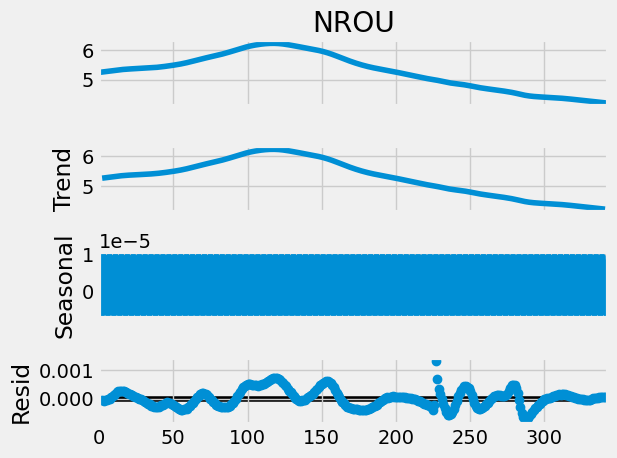

In [114]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df['NROU'], model='additive', period=4)
decomposition.plot()
plt.show()


The seasonal component in the plot is nearly flat, indicating little to no seasonality in the NROU data. This suggests that NROU is likely driven by long-term trends rather than seasonal fluctuations.

### 4. Testing for stationarity

In [115]:
print(data_sub.columns)

Index(['index', 'NROU'], dtype='object')


In [116]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['NROU'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745330
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


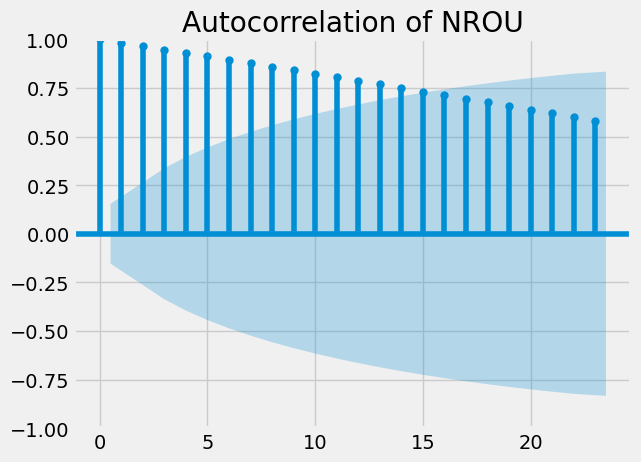

In [118]:

# Plot the autocorrelation for the 'NROU' column specifically
plot_acf(data_sub['NROU'])
plt.title("Autocorrelation of NROU")
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [119]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [120]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [121]:
data_diff.head()

,index,NROU
datetime,,
1980-04-01,1.0,-0.006662
1980-07-01,1.0,-0.007321
1980-10-01,1.0,-0.007892
1981-01-01,1.0,-0.008373
1981-04-01,1.0,-0.008762


In [122]:
data_diff.columns

Index(['index', 'NROU'], dtype='object')

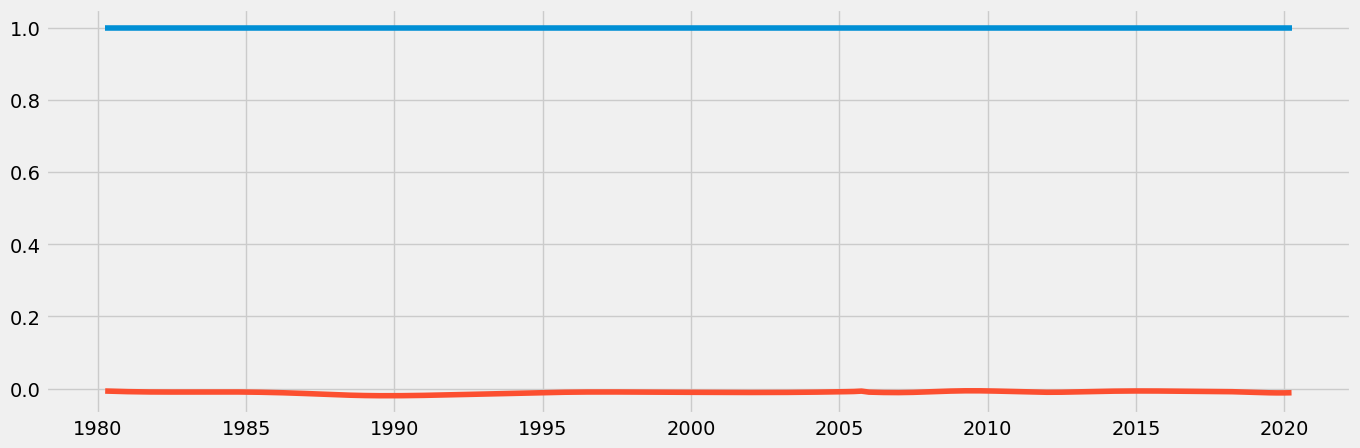

In [123]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [125]:
# Run the Dickey-Fuller test on the differenced 'NROU' series
dickey_fuller(data_diff['NROU'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


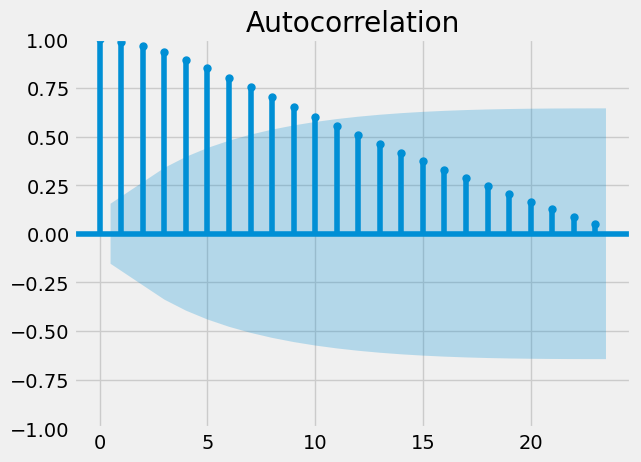

In [127]:
# Plot the autocorrelation for the differenced 'NROU' series
plot_acf(data_diff['NROU'])
plt.show()

The autocorrelation plot shows a gradual decline, suggesting a strong trend in the data but no clear seasonality. This pattern indicates the data is non-stationary and lacks repeating seasonal cycles.